In [31]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

import pickle

In [17]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
hist = hist[['high', 'low', 'open', 'volumefrom', 'volumeto', 'close']]
target_col = 'close'
print(hist.shape)
hist.head(5)

(501, 6)


,high,low,open,volumefrom,volumeto,close
time,,,,,,
2019-08-04,15038.3,12995.1,14188.7,121.17,1713944.02,14479.2
2019-08-05,15494.1,14476.7,14479.2,172.01,2613805.76,15227.1
2019-08-06,15944.9,14652.9,15227.1,84.65,1297525.18,15053.8
2019-08-07,15815.0,14750.2,15053.8,88.46,1362814.79,15776.7
2019-08-08,15824.0,15222.5,15776.7,68.75,1070396.00,15800.0


In [18]:
def train_test_split(df, test_size=0.2):
  split_row = len(df) - int(test_size * len(df))
  train_data = df.iloc[:split_row]
  test_data = df.iloc[split_row:]
  return train_data, test_data

train, test = train_test_split(hist, test_size=0.2)
train.shape, test.shape

((401, 6), (100, 6))

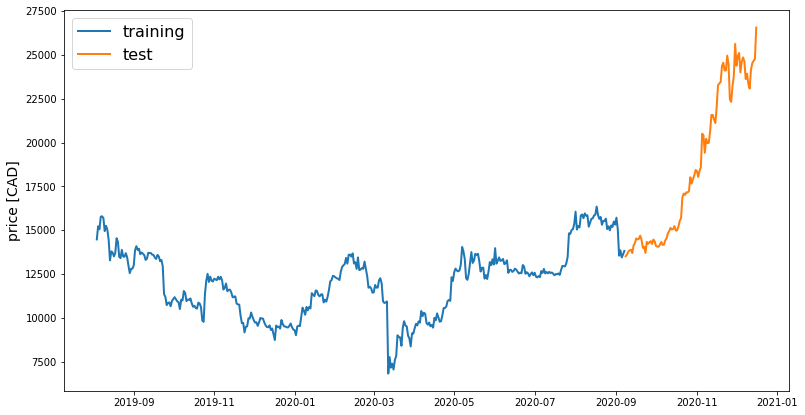

In [19]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [29]:
def normalise_zero_base(df):
  # print(df.info())
  return df / df.iloc[0] - 1

def normalise_min_max(df):
  return (df - df.min()) / (data.max() - df.min())

def extract_window_data(df, window_len=5, zero_base=True):
  window_data = []
  for idx in range(len(df) - window_len):
      tmp = df[idx: (idx + window_len)].copy()
      if zero_base:
          tmp = normalise_zero_base(tmp)
      window_data.append(tmp.values)
  return np.array(window_data)

def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
  train_data, test_data = train_test_split(df, test_size=test_size)
  X_train = extract_window_data(train_data, window_len, zero_base)
  X_test = extract_window_data(test_data, window_len, zero_base)
  y_train = train_data[target_col][window_len:].values
  y_test = test_data[target_col][window_len:].values
  if zero_base:
      y_train = y_train / train_data[target_col][:-window_len].values - 1
      y_test = y_test / test_data[target_col][:-window_len].values - 1

  return train_data, test_data, X_train, X_test, y_train, y_test

def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
  model = Sequential()
  model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_func))

  model.compile(loss=loss, optimizer=optimizer)
  return model

def save_model(model, file_name):
    """
    Save model in pickle format
    :param model: training model
    :param file_name: String
        Path to the model file
    """
    with open(file_name, 'wb') as file:
        pickle.dump(model, file)
        
def load_model(file_name):
    """
    Load model from file
    :param file_name: String
        Path to the model file
    :return: predictive model
    """
    with open(file_name, 'rb') as file:
        return pickle.load(file)

In [24]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [25]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [26]:
model = build_lstm_model( X_train, output_size=1, 
                         neurons=lstm_neurons, 
                         dropout=dropout, 
                         loss=loss, 
                         optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=epochs, 
                    batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0119
Epoch 2/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0085
Epoch 3/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 4/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0062
Epoch 5/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 6/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 7/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 8/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 9/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 10/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 11/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0052
Epoch 12/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 13/20
13/13 [==============================

In [33]:
# save in h5
# save_model(model, 'model_v1_lstm400.pkl')
model.save('model_v1_lstm400.h5')

In [34]:
# load from h5
# model = load_model(model, 'model_v1_lstm400.pkl')
model.load_weights('model_v1_lstm400.h5')

# make inference
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.022586337547267132

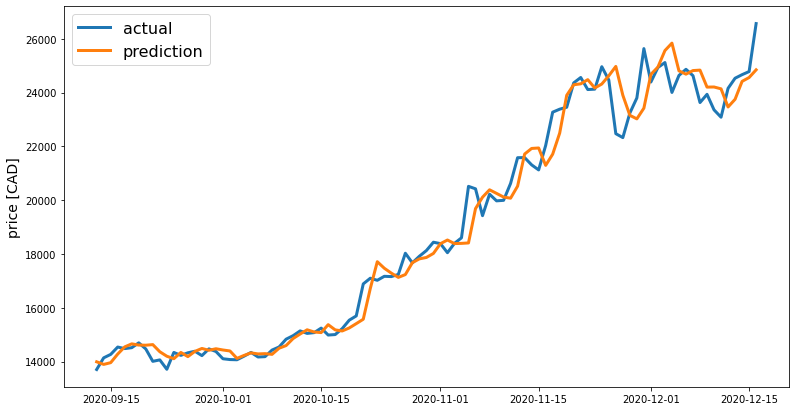

In [35]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

#### Save in pickle